In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Page Rank Analysis 2
Date: October 12, 2020
## Objectives
Isolate fragment impact from fragment frequency.  The idea is to minimize the impact of highly frequent fragments
such as `ccc`.

### Approach
1. Split molecules into "easy to predict" and "hard to predict"
    1. Top and bottom quartiles of scaled average error
    2. This might need to be **dataset specific**.  Molecules or fragments that are difficult to predict for one
      property may not be difficult for the next.  These effects will offset in an average error.
      Try logP14k without scaled error in next attempt.

2. Compare and contrast fragments from these groups.
    1. Are the most common (by number of appearances) the same?

3. Remove highly conserved fragments.  Fragments that are present in both in easy and hard to predict molecule sets
 are removed.
    1. This might remove all fragments?
    2. Maybe remove the top `n` most frequent or the top `X%` most frequent

4. Create graph projection with remaining molecules and fragments. Create unweighted and weighted graphs.

5. Run PageRank algorithm on both graph projections.
    1. Return fragments rank and score.  Collect results in CSV.

6.  Analyze results.

### Grouping Molecules by Error Prediction Error
I need to collect statistics on molecules average prediction errors.  For simplicity and minimizing variables,
I am going to just use the `Lipophilicity` dataset.  Currently, there are 11 models that have used this dataset.

**Make a difficulty property based on molecule predictions.**  This will be used to categorize molecules as hard to predict.  In the below query, I do not used the `scaled average error` because I am only looking at a single dataset.  This is not ideal since I am writing directly to the molecule node, which may be a part of more than one dataset. 
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[]-(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)
WITH avg(p.average_error) as difficulty, M, T, p
SET M.difficulty = difficulty
RETURN M,T, p
```

**Find the difficult to predict molecules.**  This query will find the molecules above the 90th percentile.  In other words, the 10% of molecules with the highest average error.
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WHERE M.difficulty > cutoff
RETURN  id(M) as NodeID, M.smiles as SMILES , M.difficulty as Difficulty, cutoff ORDER BY 
M.difficulty DESC LIMIT 100
```

**Find the most common fragments.** We want to subtract the most common fragments in the bottom 90% from the fragments in the top 10% most difficult molecules.  But first we must identify what fragments are most common.

**Most common fragments in easy molecules**
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff, count(M) as total
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE M.difficulty < cutoff
RETURN F.name, count(f), 0.9 * total as Total, toFloat(count(f)) / 0.9 / total * 100 as percent ORDER BY count(f) DESC LIMIT 100
```
**Most common fragments in hard molecules**
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff, count(M) as total
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE M.difficulty > cutoff
RETURN F.name, count(f), 0.1 * total as Total, toFloat(count(f)) / 0.1 / total * 100 as percent ORDER BY count(f) DESC LIMIT 100
```

The above Cypher command finds the most frequent fragments in the group based on number of relationships it has to molecules in the dataset.  It calculates the percent of molecules in that group that have that fragment.  

### Removing fragments that overlap molecular groups
Next we need to find what fragments are common in both the high error and less error sets.  Then isolate the ones more frequent in the high error group.

I think there are several ways we could go about making rules for which fragments to remove. 

1. We could remove the `n` most common fragments in the easy group from the hard group.

2. Remove fragments with a prevelence above a threshold, say 25%.  i.e if a fragment is present in 25% or more of the easy molecules, remove it.

3. We could remove fragments that have the same prevelence (within a threshold, say 2%) in both the hard and easy sets.

4. Remove all fragments present in the easy group from the hard group.  This will remove the most and leave fragments that *only* exist in the hard group. 

Let's start with the first approach. 

```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff

MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(eM:Molecule)-[ef:HAS_FRAGMENT]->(eF:Fragment)
WHERE eM.difficulty < cutoff // easy molecules
WITH eF, count(ef) as efreq, cutoff // gath frags and frequency
ORDER BY efreq DESC LIMIT 1000  //  limit to top n
WITH  collect(eF) as easyFrags, cutoff

MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(hM:Molecule)-[hf:HAS_FRAGMENT]->(hF:Fragment)
WHERE hM.difficulty > cutoff // hard molecules
WITH hF, count(hf) as hfreq, easyFrags
ORDER BY hfreq DESC LIMIT 1000
WITH collect(hF) as hardFrags, easyFrags

WITH apoc.coll.intersection(easyFrags, hardFrags) as overlap, apoc.coll.subtract(hardFrags, easyFrags) as remain  // use APOC to do list intersect & subtraction
RETURN size(remain), remain 
```

The above query collects the 1000 most frequent fragments in both the easy and difficult groups.  Then it calculates the overlap between the sets and the difference between them. It returns what remains of the hard group once the easy fragments have been removed.  

You can `UNWIND` the resulting list to use the nodes in a `MATCH` query.
```cypher
UNWIND remain as rFrags
MATCH (M:Molecule)-[:HAS_FRAGMENT]->(rFrags)
RETURN M, rFrags
```

This will return the molecules that have those "difficult" fragments. 



##  Graph Projections
Now there is the challenge of using the above queries to create a graph projection for use in GDS.  I believe I will need to use a Cypher projection, due to the complicated nature of the query.

```cypher
CALL gds.graph.create('mols_native_2',  // graph name
['Molecule', 'Fragment'], // Node Labels
'HAS_FRAGMENT',  // Relationship Labels
{relationshipProperties:{weight:{property: 'difficulty', defaultValue: 0}}} // Relationship properties
)
Yield graphName, nodeCount, relationshipCount;
```
This graph projection contains just molecules and molecular fragments and the relationship between them.
The Neo4j property `difficulty` is mapped to the projection under the name `weight`.

## Unweighted PageRank Algorithm

```cypher
CALL gds.pageRank.stream('mols_native',{
	maxIterations: 20
    })
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC
```

## Weighted PageRank Algorithm
```cypher
CALL gds.pageRank.stream('mols_native',{
	maxIterations: 20,
    relationshipWeightProperty: 'weight'
    })
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC
```

In [2]:
path = '/home/adam/research/neo4j/gds_results/pageRank/'
df_w = pd.read_csv(path + 'mol_frags_weight_2.csv')
df_n = pd.read_csv(path + 'mol_frags_noweight_2.csv')

n = 5000  # counter for n highest results

In [3]:
df_n.shape

(11276, 2)

In [4]:
def cleanup(df, n = 0):
    """
    Quick function to process incoming dataframes.
    Accepts a data frame and a integer for how many entries to keep.
    """
    df = df.dropna()
    df["rank"] = df.index + 1
    if n == 0:
        n = df.shape[0]
    df = df[:n]
    
    return df
    

In [5]:
# df_w["rank"] = df_w.index + 1
# df_w = df_w[:n]
# df_w.head(10)
df_w = cleanup(df_w)
df_w.describe()

/home/adam/miniconda3/envs/mlapp/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,score,rank
count,215.000000,215.000000
mean,4.709755,108.000000
std,6.572809,62.209324
min,0.225836,1.000000
25%,0.847697,54.500000
50%,2.188870,108.000000
75%,5.147408,161.500000
max,34.859251,215.000000


In [6]:
df_n = cleanup(df_n)
df_n.describe()

/home/adam/miniconda3/envs/mlapp/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,score,rank
count,215.000000,215.000000
mean,6.709431,108.000000
std,10.328306,62.209324
min,0.233121,1.000000
25%,1.077265,54.500000
50%,2.931312,108.000000
75%,7.109225,161.500000
max,72.474732,215.000000


### Clean up Results
We need to merge the two results into one dataframe.
One column with the fragment, one with unweighted scores,
one with the weighted scores.

Once that is done, we can see how we can manipulate them to get answers.

In [7]:
df = pd.merge(df_n, df_w, on="name", how='outer', suffixes=("_no_weight", "_weight"))
df.dropna()
df["score_diff"] = df["score_weight"] - df["score_no_weight"]

# Negative rank diff means fragment became more important with weight!
df["rank_diff"] = df["rank_weight"] - df["rank_no_weight"]

# Positive frac means fragment became more important with weight
df["frac"] = (df["score_weight"] - df["score_no_weight"])/df["score_no_weight"]*100
# df = df[np.abs(df.score_diff) > 0.01]
df.sort_values(by="rank_diff", ascending=True).head(25)
# df.head(25)

,name,score_no_weight,rank_no_weight,score_weight,rank_weight,score_diff,rank_diff,frac
136,cOC<-C(=O)O>,1.903568,137,1.648504,124,-0.255064,-13,-13.399266
129,c<-C(=O)O>cccC,2.130654,130,1.967636,117,-0.163018,-13,-7.651072
96,cc(c)OC<-C(=O)O>,3.423246,97,2.976932,84,-0.446314,-13,-13.037736
82,c<=O>[nH]c<=O>,4.162912,83,3.707889,70,-0.455023,-13,-10.930395
87,cc[nH]c-c,3.893999,88,3.332488,76,-0.561511,-12,-14.419899
117,c<-C(=O)O>cnc,2.504248,118,2.202081,106,-0.302167,-12,-12.066165
130,cc<=O>[nH]c<=O>,2.128764,131,1.916958,119,-0.211806,-12,-9.949724
99,c<=O>cc(n)n,3.370520,100,2.849507,88,-0.521014,-12,-15.457962
86,ccOC<-C(=O)O>,3.996996,87,3.391307,75,-0.605689,-12,-15.153610
90,cccOC<-C(=O)O>,3.773871,91,3.200057,80,-0.573814,-11,-15.204906


In [8]:
df.describe()

,score_no_weight,rank_no_weight,score_weight,rank_weight,score_diff,rank_diff,frac
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,6.709431,108.000000,4.709755,108.000000,-1.999676,0.000000,-22.455193
std,10.328306,62.209324,6.572809,62.209324,4.731761,12.550459,13.459472
min,0.233121,1.000000,0.225836,1.000000,-49.973981,-13.000000,-90.057332
25%,1.077265,54.500000,0.847697,54.500000,-1.782157,-5.500000,-27.668701
50%,2.931312,108.000000,2.188870,108.000000,-0.629884,-1.000000,-19.129873
75%,7.109225,161.500000,5.147408,161.500000,-0.166391,2.000000,-14.477751
max,72.474732,215.000000,34.859251,215.000000,-0.007286,107.000000,-3.125292


<IPython.core.display.Javascript object>


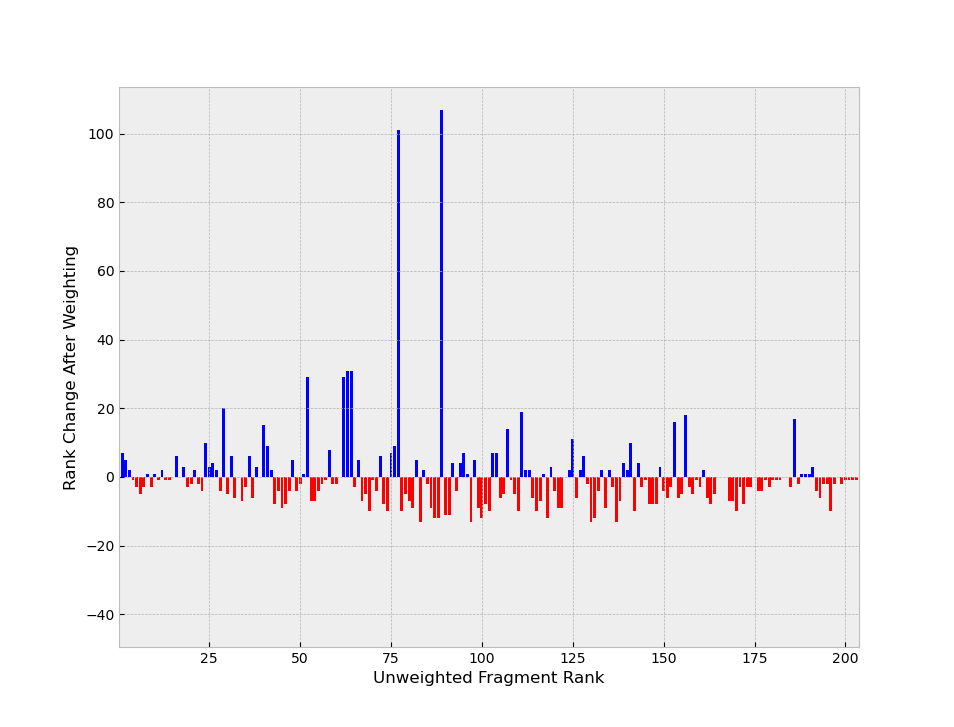

(0.0, 226.14000000000001)

In [9]:
%matplotlib notebook
plt.style.use('bmh')
dff=df[:1000]
fig, ax = plt.subplots()
# ax = plt.subplot(111)
ax.bar(dff.rank_no_weight, dff.rank_diff, color=(dff['rank_diff'] > 0).map({True: 'b', False: 'r'}))
plt.xlabel("Unweighted Fragment Rank")
plt.ylabel("Rank Change After Weighting")
plt.ylim(-125, 125)
plt.xlim(0,)
# plt.show()
# plt.close()


Change the number of points the graph looks at.  Interestingly, you can see that as `n` increases, the `rank_diff` tends to also increase.  This is largely because very little score separates entries at high ranks (low score).  So a small delta in score can cause a large jump in rank

<IPython.core.display.Javascript object>


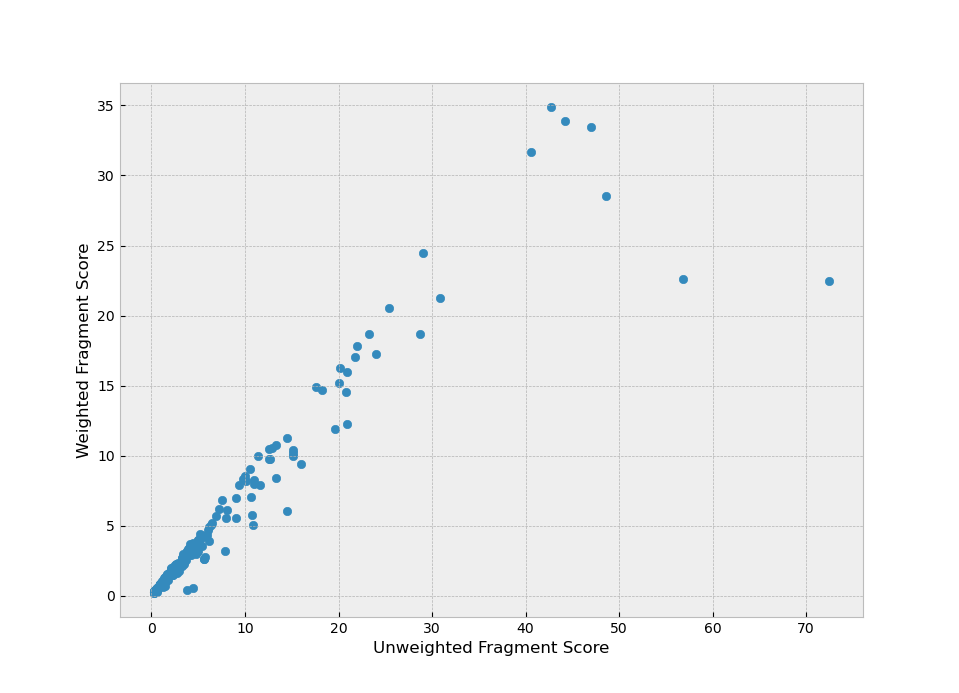

Text(0, 0.5, 'Weighted Fragment Score')

In [10]:
dff=df[:2500]  # adjust what data to look at here
plt.style.use('bmh')
fig, ax = plt.subplots()
ax.scatter(dff.score_no_weight, dff.score_weight)
plt.xlabel("Unweighted Fragment Score")
plt.ylabel("Weighted Fragment Score")